In [ ]:
!gdown 1iSBaLC-SaT10WLHPwUVBXzo-T2CPUp3P

Downloading...
From: https://drive.google.com/uc?id=1iSBaLC-SaT10WLHPwUVBXzo-T2CPUp3P
To: /content/data.csv
100% 91.7k/91.7k [00:00<00:00, 40.3MB/s]


# Задание 

1. Произвести первичный анализ и очистку данных (там точно есть дубликаты фильмов, тк один фильм может иметь несколько режиссеров, а в запросе это не учтено).
2. Проанализировать пространство признаков. Попытаться выявить закономерности, произвести отбор. При необходимости построить дополнительные признаки.
3. Построить модель предсказания рейтинга фильма (кассовые сборы для тестовых объектов в таком случае считать неизвестными).
4. Построить модель предсказания кассовых сборов фильма для двух случаев: рейтинг неизвестен; известный рейтинг считать оценкой истинного рейтинга, например, после первых нескольких дней в прокате или рейтингом, который присвоила фокус группа на закрытых показах).

Задание выполнять в .ipynb блокноте. Комментарии и выводы обязательны. Для проверки должны быть представлены .ipynb и .html версии блокнотов.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,film,box_office,cost,film_duration,kinopoisk_id,dirLabel,film_label,d,kp_num_votes,kp_rating,imdb_num_votes,imdb_rating
0,http://www.wikidata.org/entity/Q128493,44093316.0,10500000,105,467553,Robert Rodriguez,Machete,2010,77248,6.461,193459,6.6
1,http://www.wikidata.org/entity/Q128493,44093316.0,10500000,105,467553,Ethan Maniquis,Machete,2010,77248,6.461,193459,6.6
2,http://www.wikidata.org/entity/Q28369564,18844022.0,11000000,119,1008385,Craig Gillespie,"I, Tonya",2017,108131,7.311,196744,7.5
3,http://www.wikidata.org/entity/Q25339940,43980821.0,11000000,107,958442,Taylor Sheridan,Wind River,2017,132469,7.508,220094,7.7
4,http://www.wikidata.org/entity/Q175600,4600000.0,11000000,122,54549,Wim Wenders,Don't Come Knocking,2005,1212,6.639,7475,6.6


In [ ]:
df.shape

(692, 12)

## Очистка данных

Проверим данные на дубликаты

In [ ]:
df.film.value_counts()

http://www.wikidata.org/entity/Q27188178    20
http://www.wikidata.org/entity/Q31188935     6
http://www.wikidata.org/entity/Q18407657     6
http://www.wikidata.org/entity/Q18486021     6
http://www.wikidata.org/entity/Q20977110     5
                                            ..
http://www.wikidata.org/entity/Q17436508     1
http://www.wikidata.org/entity/Q432582       1
http://www.wikidata.org/entity/Q860734       1
http://www.wikidata.org/entity/Q725539       1
http://www.wikidata.org/entity/Q28790662     1
Name: film, Length: 578, dtype: int64

Для начала удалим дубликаты, где режиссер с ссылкой на фильм повторяются

In [ ]:
df.drop_duplicates(subset=['film', 'dirLabel'], inplace=True)

In [ ]:
df.shape

(607, 12)

Найдем фильмы, у которых есть несколько режиссеров и из-за этого они повторяются

In [ ]:
sub_df = df[df.duplicated(subset='film', keep=False)][['dirLabel', 'film_label']]
sub_df.head()

,dirLabel,film_label
0,Robert Rodriguez,Machete
1,Ethan Maniquis,Machete
17,Dan Cutforth,Katy Perry: Part of Me
18,Jane Lipsitz,Katy Perry: Part of Me
58,Ricky Gervais,The Invention of Lying


Объединим режиссеров чтобы у фильма было их несколько

In [ ]:
directors_dict = {}

In [ ]:
sub_df.film_label.unique()

array(['Machete', 'Katy Perry: Part of Me', 'The Invention of Lying',
       'Bad Moms', 'Daybreakers', 'Hail, Caesar!',
       'No Country for Old Men', 'Battle of the Sexes', 'I Feel Pretty',
       'Bandidas', 'Game Night', 'True Grit', 'Sin City', 'Corpse Bride',
       'Aliens vs. Predator: Requiem', 'Office Christmas Party',
       'Crazy, Stupid, Love.', 'Focus', '21 Jump Street',
       '22 Jump Street', 'Underworld: Awakening', 'Minions',
       'The Bourne Supremacy', 'The Book of Eli', 'Bad Boys for Life',
       'Frozen', 'Captain America: The Winter Soldier',
       'Captain America: Civil War'], dtype=object)

In [ ]:
' '.join(sub_df[sub_df.film_label == 'Machete'].values[:, 0])

'Robert Rodriguez Ethan Maniquis'

In [ ]:
# для каждого фильма дубликата собираем список его режиссеров
for film_name in sub_df.film_label.unique():
  directors_dict[film_name] = ' '.join(sub_df[sub_df.film_label == film_name].values[:, 0])

In [ ]:
directors_dict

{'Machete': 'Robert Rodriguez Ethan Maniquis',
 'Katy Perry: Part of Me': 'Dan Cutforth Jane Lipsitz',
 'The Invention of Lying': 'Ricky Gervais Matthew Robinson',
 'Bad Moms': 'Jon Lucas Scott Moore',
 'Daybreakers': 'Michael Spierig Peter Spierig',
 'Hail, Caesar!': 'Joel Coen Ethan Coen',
 'No Country for Old Men': 'Joel Coen Ethan Coen',
 'Battle of the Sexes': 'Valerie Faris Jonathan Dayton',
 'I Feel Pretty': 'Marc Silverstein Abby Kohn',
 'Bandidas': 'Joachim Rønning Espen Sandberg',
 'Game Night': 'John Francis Daley Jonathan Goldstein',
 'True Grit': 'Joel Coen Ethan Coen',
 'Sin City': 'Quentin Tarantino Robert Rodriguez Frank Miller',
 'Corpse Bride': 'Tim Burton Mike Johnson',
 'Aliens vs. Predator: Requiem': 'Greg Strause Colin Strause',
 'Office Christmas Party': 'Will Speck Josh Gordon',
 'Crazy, Stupid, Love.': 'Glenn Ficarra John Requa',
 'Focus': 'Glenn Ficarra John Requa',
 '21 Jump Street': 'Phil Lord Chris Miller',
 '22 Jump Street': 'Phil Lord Chris Miller',
 'Und

Создадим датафрейм с режиссерами и присоединим его к уже существующему

In [ ]:
more_one_director_films = pd.DataFrame(data=directors_dict, index=[0])
#переимениуем колонку с индексом чтобы потом можно было её объединить с нашим датафреймом
more_one_director_films.index.name = 'film_label'
# транспонируем чтобы получилась таблица как изначальный датафрейм
more_one_director_films = more_one_director_films.T
more_one_director_films.rename({0:'directors'}, axis=1, inplace=True)
more_one_director_films.head()

film_label,directors
Machete,Robert Rodriguez Ethan Maniquis
Katy Perry: Part of Me,Dan Cutforth Jane Lipsitz
The Invention of Lying,Ricky Gervais Matthew Robinson
Bad Moms,Jon Lucas Scott Moore
Daybreakers,Michael Spierig Peter Spierig


In [ ]:
df = df.join(more_one_director_films, on='film_label', how='left')

Заполним NaN значения

In [ ]:
for i in range(len(df)):
  if df.iloc[i, 12] is np.nan:
    df.iloc[i, 12] = df.iloc[i, 5]

In [ ]:
df.head()

,film,box_office,cost,film_duration,kinopoisk_id,dirLabel,film_label,d,kp_num_votes,kp_rating,imdb_num_votes,imdb_rating,directors
0,http://www.wikidata.org/entity/Q128493,44093316.0,10500000,105,467553,Robert Rodriguez,Machete,2010,77248,6.461,193459,6.6,Robert Rodriguez Ethan Maniquis
1,http://www.wikidata.org/entity/Q128493,44093316.0,10500000,105,467553,Ethan Maniquis,Machete,2010,77248,6.461,193459,6.6,Robert Rodriguez Ethan Maniquis
2,http://www.wikidata.org/entity/Q28369564,18844022.0,11000000,119,1008385,Craig Gillespie,"I, Tonya",2017,108131,7.311,196744,7.5,Craig Gillespie
3,http://www.wikidata.org/entity/Q25339940,43980821.0,11000000,107,958442,Taylor Sheridan,Wind River,2017,132469,7.508,220094,7.7,Taylor Sheridan
4,http://www.wikidata.org/entity/Q175600,4600000.0,11000000,122,54549,Wim Wenders,Don't Come Knocking,2005,1212,6.639,7475,6.6,Wim Wenders


Заменим старый столбец с режиссерами на новый

In [ ]:
df.drop('dirLabel', axis=1, inplace=True)
df.rename({'directors':'dirLabel'}, axis=1, inplace=True)
df.head()

,film,box_office,cost,film_duration,kinopoisk_id,film_label,d,kp_num_votes,kp_rating,imdb_num_votes,imdb_rating,dirLabel
0,http://www.wikidata.org/entity/Q128493,44093316.0,10500000,105,467553,Machete,2010,77248,6.461,193459,6.6,Robert Rodriguez Ethan Maniquis
1,http://www.wikidata.org/entity/Q128493,44093316.0,10500000,105,467553,Machete,2010,77248,6.461,193459,6.6,Robert Rodriguez Ethan Maniquis
2,http://www.wikidata.org/entity/Q28369564,18844022.0,11000000,119,1008385,"I, Tonya",2017,108131,7.311,196744,7.5,Craig Gillespie
3,http://www.wikidata.org/entity/Q25339940,43980821.0,11000000,107,958442,Wind River,2017,132469,7.508,220094,7.7,Taylor Sheridan
4,http://www.wikidata.org/entity/Q175600,4600000.0,11000000,122,54549,Don't Come Knocking,2005,1212,6.639,7475,6.6,Wim Wenders


In [ ]:
# теперь с чистой душой можно удалить все дубликаты фильмов, не потеряв режиссеров
df.drop_duplicates(subset=['film'], inplace=True)

In [ ]:
df.film.value_counts()

http://www.wikidata.org/entity/Q128493      1
http://www.wikidata.org/entity/Q25431158    1
http://www.wikidata.org/entity/Q29021224    1
http://www.wikidata.org/entity/Q20762680    1
http://www.wikidata.org/entity/Q221384      1
                                           ..
http://www.wikidata.org/entity/Q155476      1
http://www.wikidata.org/entity/Q550196      1
http://www.wikidata.org/entity/Q326114      1
http://www.wikidata.org/entity/Q25136669    1
http://www.wikidata.org/entity/Q28790662    1
Name: film, Length: 578, dtype: int64

In [ ]:
df.shape

(578, 12)

In [ ]:
print('Количество данных после чистки уменьшилось на', 692 - 578, 'фильма')

Количество данных после чистки уменьшилось на 114 фильма


## Исследование данных

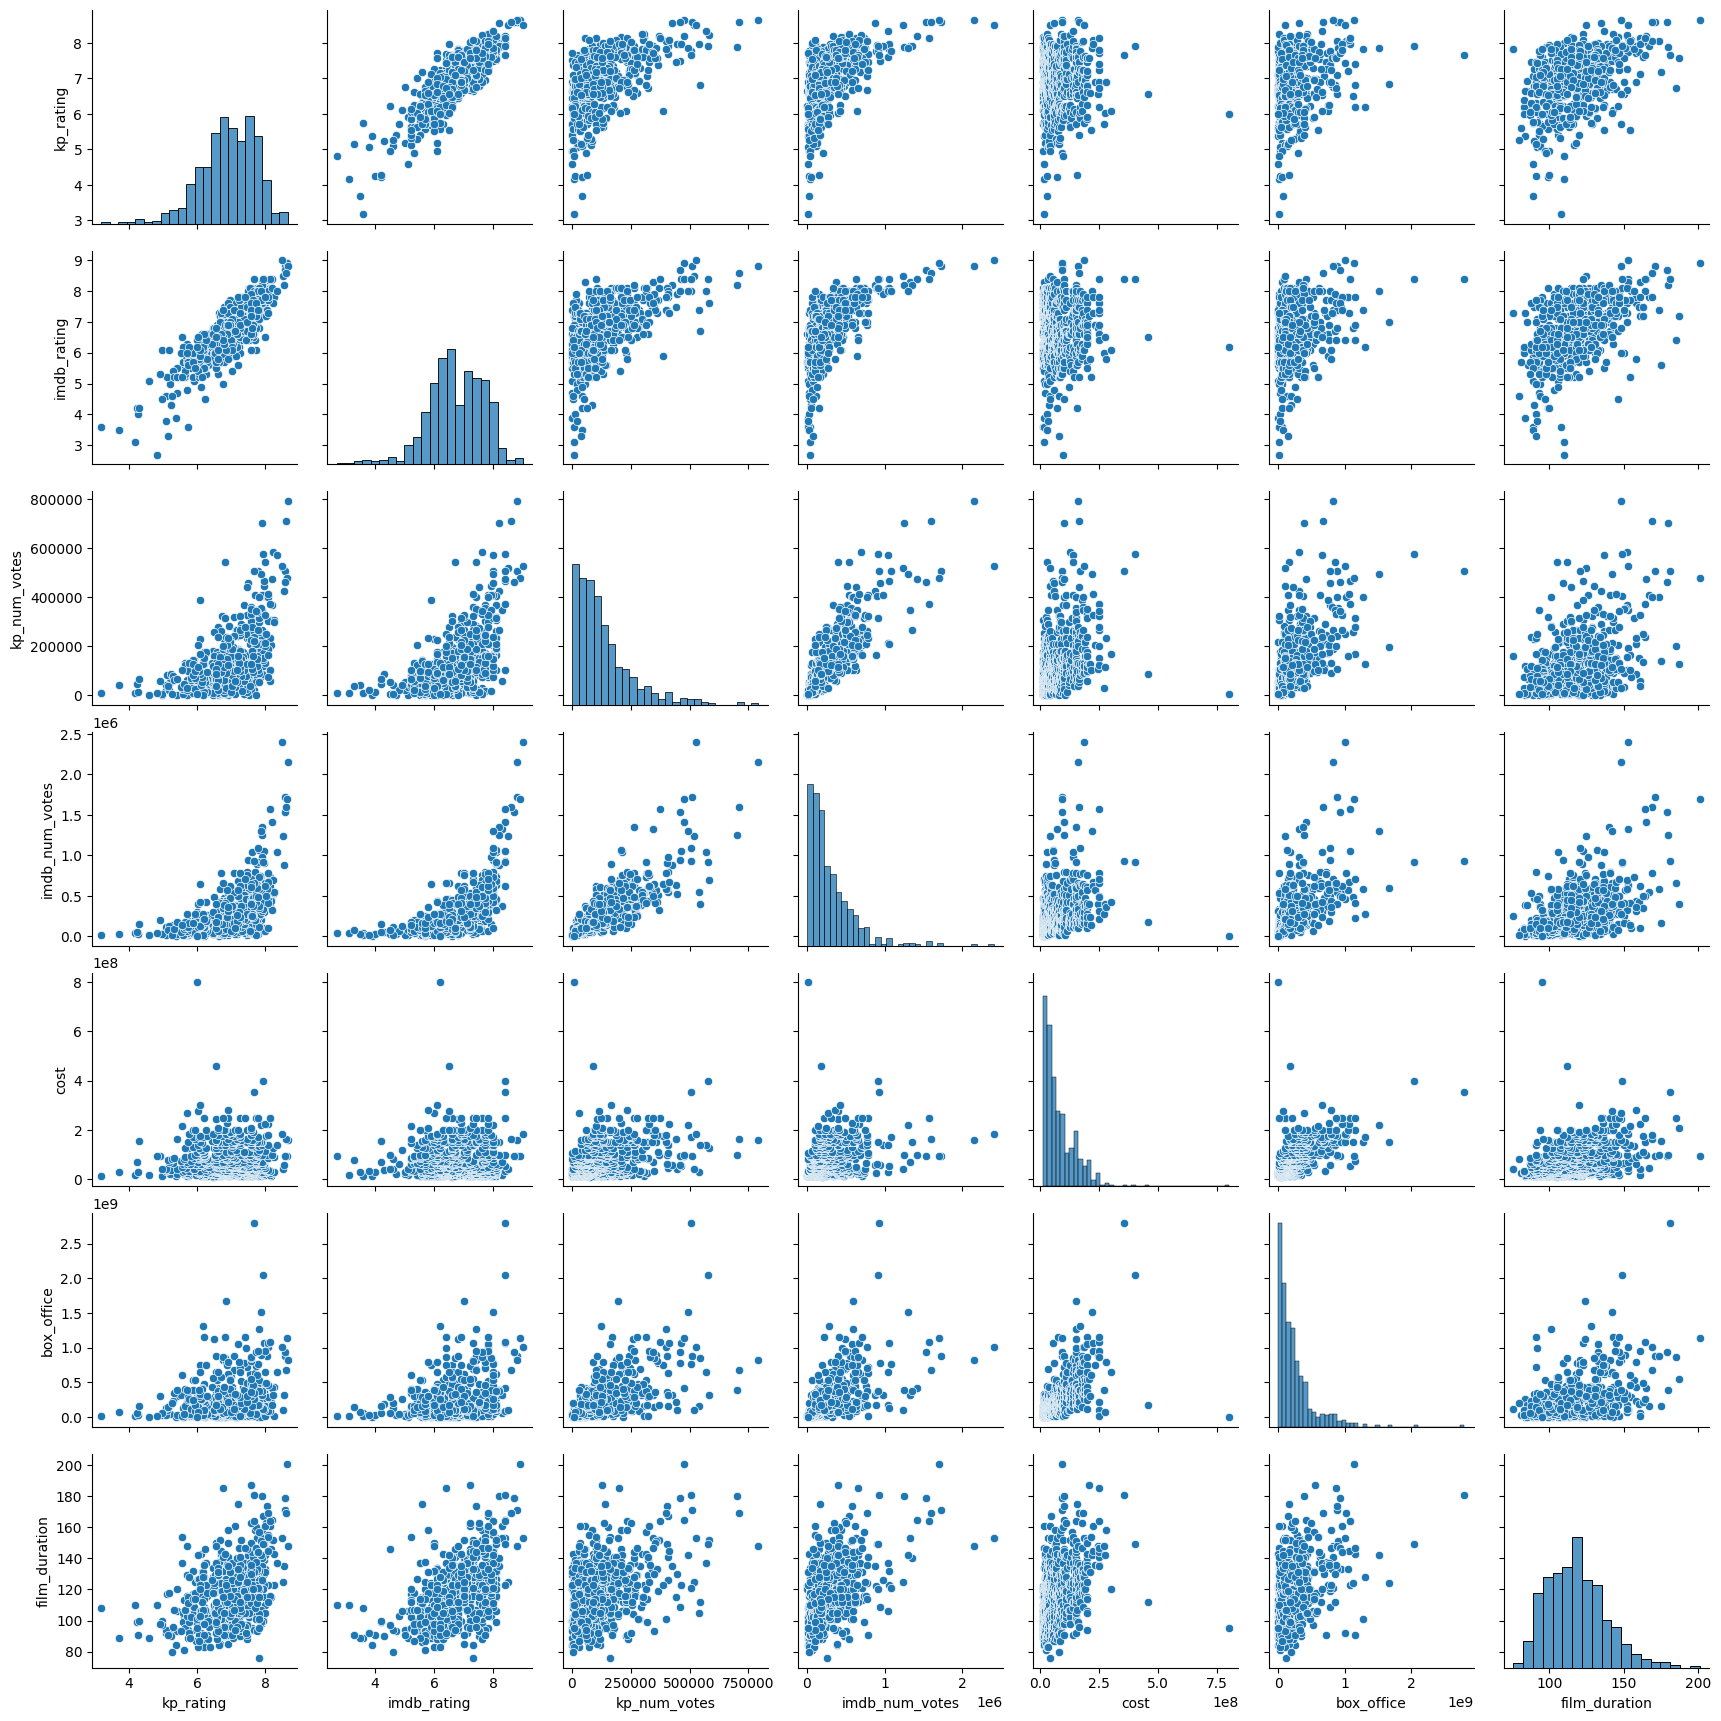

In [ ]:
sns.pairplot(df, vars=["kp_rating",
                       "imdb_rating",
                       "kp_num_votes",
                       "imdb_num_votes",
                       "cost",
                       "box_office",
                       "film_duration"
                       ]);

In [ ]:
df.corr()

,box_office,cost,film_duration,kinopoisk_id,d,kp_num_votes,kp_rating,imdb_num_votes,imdb_rating
box_office,1.000000,0.592544,0.419982,0.063519,0.122978,0.609219,0.261505,0.574676,0.304143
cost,0.592544,1.000000,0.362715,0.073140,0.138348,0.351183,0.040546,0.308798,0.048806
film_duration,0.419982,0.362715,1.000000,0.037390,0.078008,0.451440,0.435371,0.492272,0.483072
kinopoisk_id,0.063519,0.073140,0.037390,1.000000,0.895586,0.046536,-0.239452,-0.094196,-0.002872
d,0.122978,0.138348,0.078008,0.895586,1.000000,0.085369,-0.260441,-0.054645,0.008507
kp_num_votes,0.609219,0.351183,0.451440,0.046536,0.085369,1.000000,0.552938,0.830939,0.562115
kp_rating,0.261505,0.040546,0.435371,-0.239452,-0.260441,0.552938,1.000000,0.569795,0.858587
imdb_num_votes,0.574676,0.308798,0.492272,-0.094196,-0.054645,0.830939,0.569795,1.000000,0.651704
imdb_rating,0.304143,0.048806,0.483072,-0.002872,0.008507,0.562115,0.858587,0.651704,1.000000


Из графиков можно сделать следующие выводы:
* Сильная корреляция между данными отсутствует
*  Длинные фильмы (более 150 минут) редко получают низкие оценки
* Популярные фильмы, с большим количеством оценок, получают оценки выше
* Стоимость фильма не влияет на его оценку
* Большие сборы соответвуют большому количеству оценок и длительности фильма

## Создание дополнительных признаков


Добавим усредненный балл

In [ ]:
df['mean_rating'] = (df.kp_rating + df.imdb_rating) / 2
df.shape

(578, 13)

Добавим новые фичи на основании данных режиссера. Добавим то, насколько баллов оценивают фильмы данного режиссера (или группы режиссеров) и его известность: сколько людей в среднем знают о фильмах режиссера.

In [ ]:
director_df = pd.read_csv('data.csv')
director_df['mean_rating'] = (df.kp_rating + df.imdb_rating) / 2
df_1 = df.groupby(by='dirLabel') \
        .agg({'mean_rating': 'mean', 'film': 'count', 'kp_num_votes': 'sum', 'imdb_num_votes': 'sum'}) \
        .sort_values(by='film', ascending=False) \
        .rename({'mean_rating': 'director_mean_rating', 'film': 'director_count_films'}, axis=1)
df_1['director_famous'] = np.log10((df_1.kp_num_votes + df_1.imdb_num_votes) / df_1.director_count_films)

df_1.sort_values(by='director_famous', ascending=False).head(10)

,director_mean_rating,director_count_films,kp_num_votes,imdb_num_votes,director_famous
dirLabel,,,,,
Christopher Nolan,8.137056,9,3759991,11619589,6.232702
Russo brothers,8.094500,2,1082918,1842423,6.165147
Quentin Tarantino,7.975900,5,1609502,5043546,6.124051
James McTeigue,7.962000,1,209622,1062785,6.104626
Peter Jackson,7.979438,8,2710332,7423995,6.102705
James Gunn,7.738750,2,839324,1693884,6.102641
George Miller,7.958000,1,317120,922168,6.093172
Joss Whedon,7.574333,3,906675,2378211,6.039399
Scott Derrickson,7.482500,1,442749,638483,6.033919


In [ ]:
df = df.join(df_1[['director_mean_rating', 'director_famous']], on='dirLabel', how='left')

In [ ]:
df.sort_values(by='director_mean_rating', ascending=False).head()

,film,box_office,cost,film_duration,kinopoisk_id,film_label,d,kp_num_votes,kp_rating,imdb_num_votes,imdb_rating,dirLabel,mean_rating,director_mean_rating,director_famous
162,http://www.wikidata.org/entity/Q182692,8.347151e+07,31500000,153,354,Apocalypse Now,2019,104016,8.134,627369,8.4,Francis Ford Coppola,8.2670,8.267000,5.864146
52,http://www.wikidata.org/entity/Q190956,5.600000e+07,18000000,161,397,Amadeus,2013,57176,8.153,380882,8.3,Miloš Forman,8.2265,8.226500,5.641532
649,http://www.wikidata.org/entity/Q63985561,3.613000e+08,200000000,150,1236063,Tenet,2020,352274,7.568,411718,7.4,Christopher Nolan,7.4840,8.137056,6.232702
214,http://www.wikidata.org/entity/Q46551,1.096763e+08,40000000,125,195334,The Prestige,2006,520033,8.521,1238853,8.5,Christopher Nolan,8.5105,8.137056,6.232702
613,http://www.wikidata.org/entity/Q163872,1.004934e+09,185000000,153,111543,The Dark Knight,2008,526384,8.496,2406420,9.0,Christopher Nolan,8.7480,8.137056,6.232702


Возьмем логарифм от больших чисел, так модель будет лучше ориентироваться в данных

In [ ]:
df.box_office = np.log10(df.box_office)
df.cost = np.log10(df.cost)
df.kp_num_votes = np.log10(df.kp_num_votes)
df.imdb_num_votes = np.log10(df.imdb_num_votes)
df.head()

,film,box_office,cost,film_duration,kinopoisk_id,film_label,d,kp_num_votes,kp_rating,imdb_num_votes,imdb_rating,dirLabel,mean_rating,director_mean_rating,director_famous
0,http://www.wikidata.org/entity/Q128493,7.644373,7.021189,105,467553,Machete,2010,4.887887,6.461,5.286589,6.6,Robert Rodriguez Ethan Maniquis,6.5305,6.5305,5.432499
2,http://www.wikidata.org/entity/Q28369564,7.275174,7.041393,119,1008385,"I, Tonya",2017,5.033950,7.311,5.293901,7.5,Craig Gillespie,7.4055,7.4055,5.484122
3,http://www.wikidata.org/entity/Q25339940,7.643263,7.041393,107,958442,Wind River,2017,5.122114,7.508,5.342608,7.7,Taylor Sheridan,7.6040,7.6040,5.547237
4,http://www.wikidata.org/entity/Q175600,6.662758,7.041393,122,54549,Don't Come Knocking,2005,3.083503,6.639,3.873611,6.6,Wim Wenders,6.6195,6.6195,3.938870
5,http://www.wikidata.org/entity/Q1656254,7.120450,7.041393,94,252886,I Think I Love My Wife,2007,3.076276,5.724,4.224222,5.5,Chris Rock,5.6120,5.6120,4.254064


Посмотрим на распределение наших данных, нет ли в них экстремальных значений

In [ ]:
num_cols=["box_office","cost","film_duration","director_mean_rating","director_famous","mean_rating"]

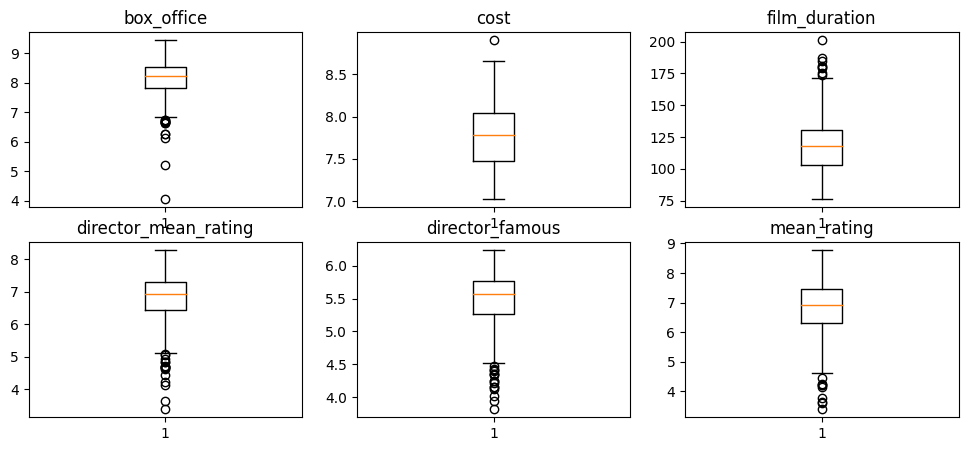

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(12,5))
                    
ax = ax.ravel()
                    
for i, column in enumerate(num_cols):
    ax[i].set_title(column)
    ax[i].boxplot(data=df, x=column)
plt.show()

В данных присутствует множество экстремальных значений, которые могут мешать обучению модели.

Сначала обучим модель на обрезанных данных, чтобы она уловила закономерность. Затем проверим её на полных данных

In [ ]:
cut_df = df.query('box_office >= 7.0 and cost <= 8.6 and film_duration <= 170 and director_mean_rating >= 5 and director_famous >= 4.5 and mean_rating >= 4.7')

In [ ]:
cut_df.shape

(528, 15)

In [ ]:
print('Количество данных после чистки уменьшилось на', 692 - 528, 'фильма')

Количество данных после чистки уменьшилось на 164 фильма


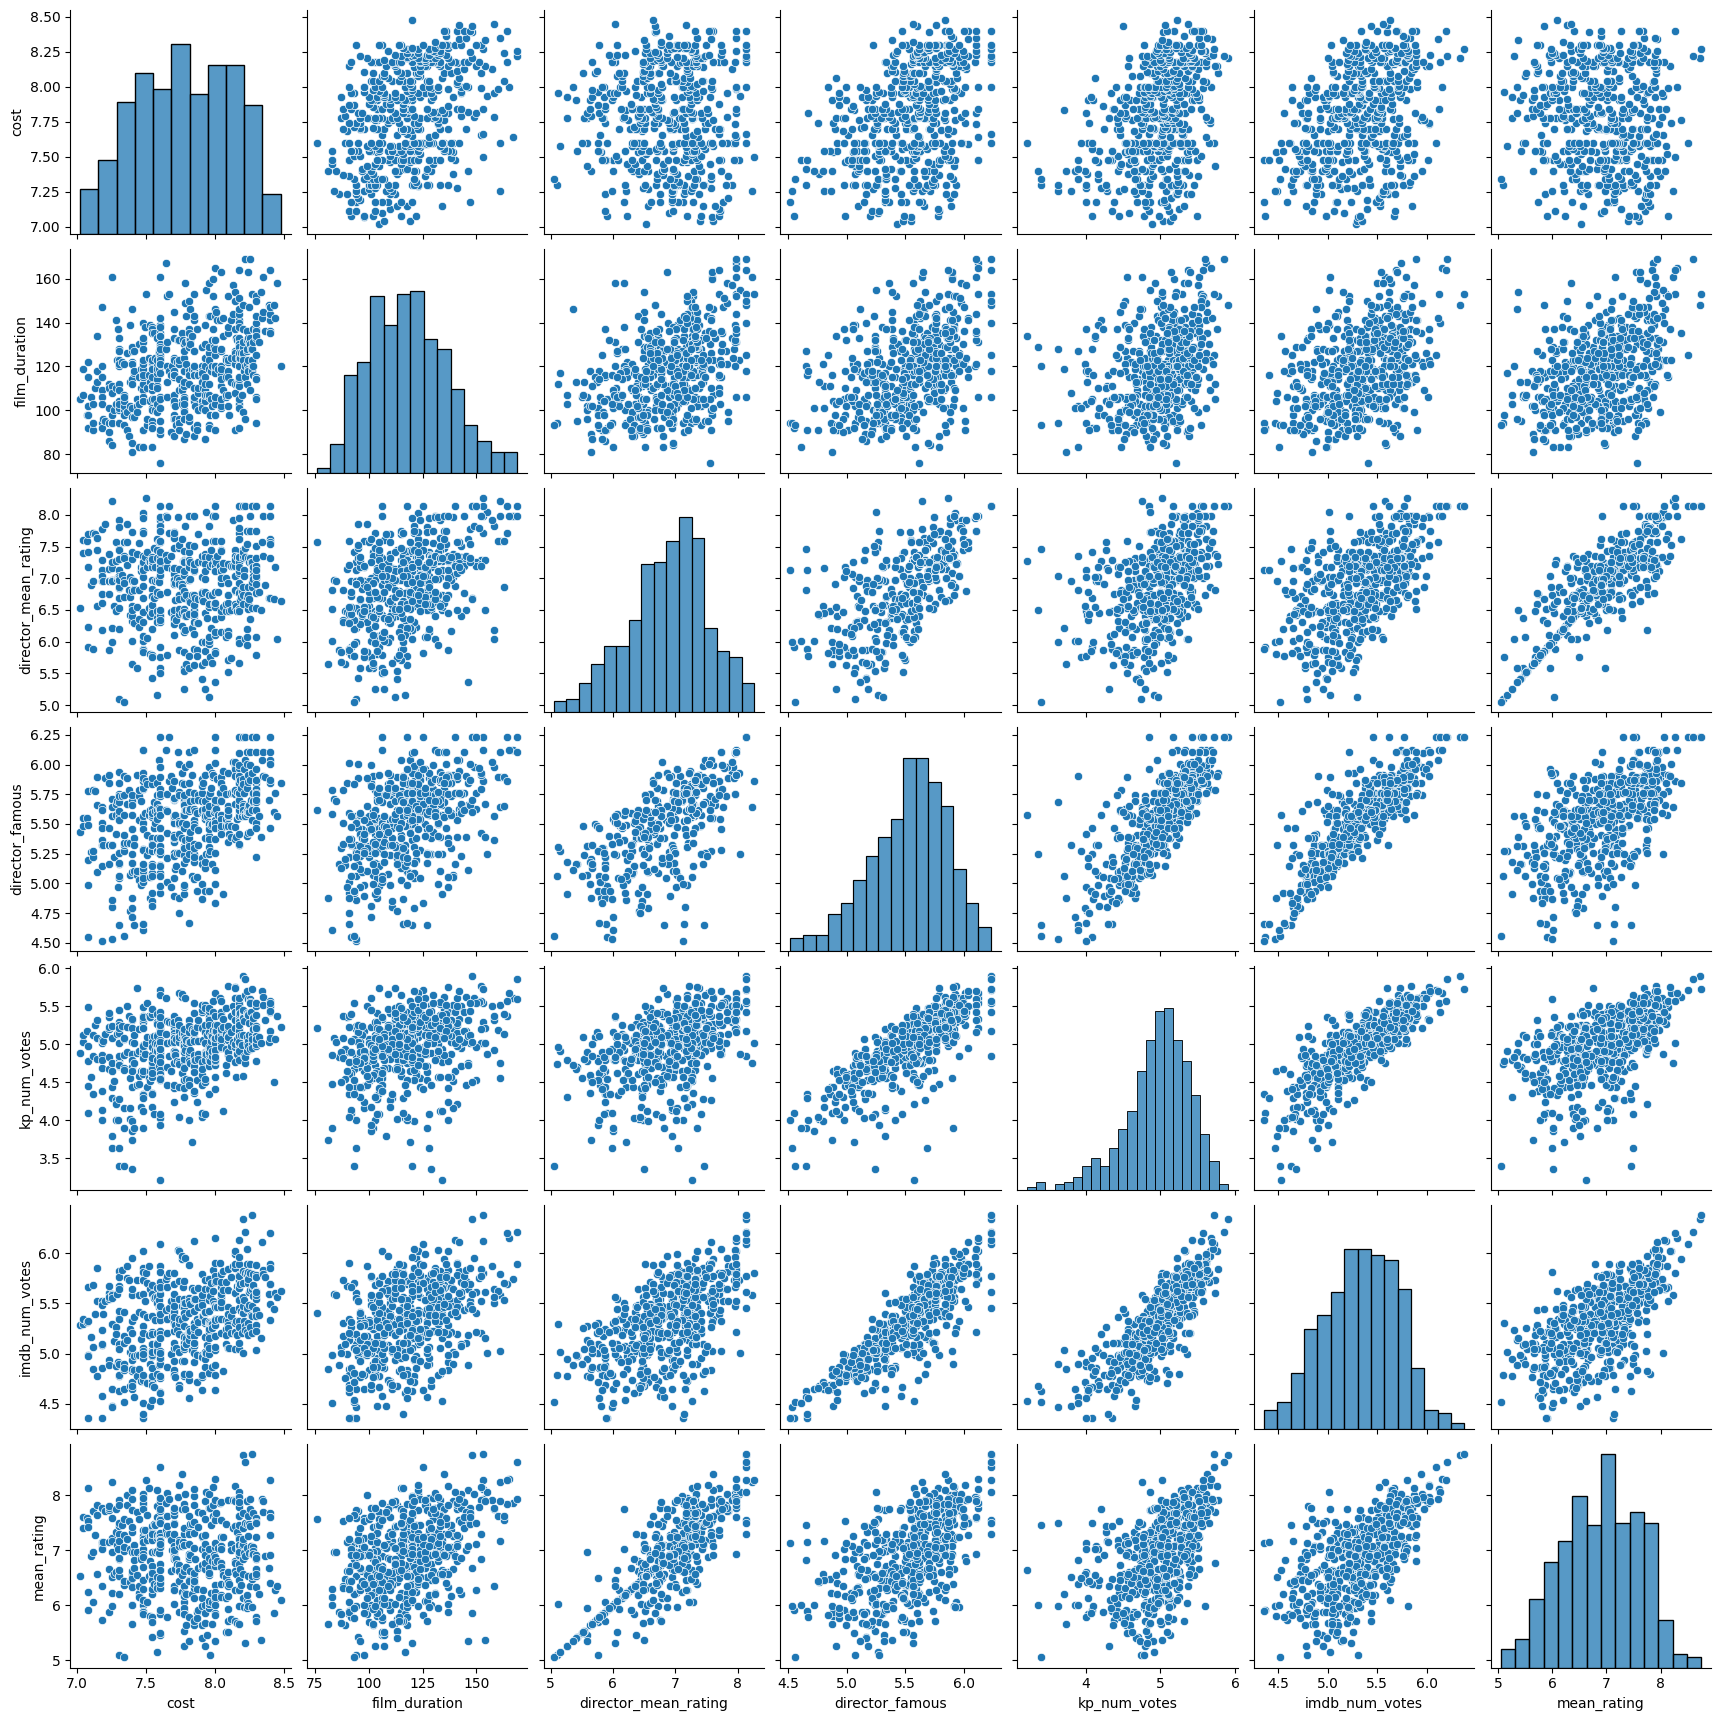

In [ ]:
sns.pairplot(cut_df, vars=["cost", "film_duration","director_mean_rating","director_famous", "kp_num_votes", "imdb_num_votes", 'mean_rating']);

## Модель предсказания рейтинга фильма

Как видно из графиков, очищенные данные образуют линейную зависимость. С такими данными хорошо справиться линейная регрессия

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X = cut_df[["film_duration","director_mean_rating","director_famous", "kp_num_votes", "imdb_num_votes"]]
y = cut_df[['mean_rating']]

In [ ]:
X.head()

,film_duration,director_mean_rating,director_famous,kp_num_votes,imdb_num_votes
0,105,6.5305,5.432499,4.887887,5.286589
2,119,7.4055,5.484122,5.033950,5.293901
3,107,7.6040,5.547237,5.122114,5.342608
6,98,7.5870,5.547405,5.171925,5.309911
7,98,7.1845,4.985103,4.453792,4.985193


Добавим 90% в обучающую выборку. Данных не так уж и много, велик риск недообучить модель

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=3365, shuffle=True)

In [ ]:
scaler =  StandardScaler()

X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)
mean_squared_error(y_test, lr.predict(X_test_transformed), squared=False)

0.29167116756863926

Модель даёт оценку фильму с разбросом в 0,3 балла

In [ ]:
def predict_random_example(X, y, model, transformer):
  i = np.random.randint(0, len(X))
  X_example = X.iloc[i, :]
  y_example = y.iloc[i, :]
  X_ex_tr = transformer.transform(X_example.to_numpy().reshape(1, -1))
  y_true = round(y_example.values[0],3)
  y_pred = round(model.predict(X_ex_tr)[0][0],3)
  error = round(((y_true - y_pred) / y_true) * 100, 3)
  print('Prediction:', y_pred, '\nTrue value:', y_true, '\nError:', error, '%')

In [ ]:
predict_random_example(X_test, y_test, lr, scaler)

Prediction: 6.275 
True value: 6.234 
Error: -0.658 %


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Проверим модель на всех данных, включая экстремальные значения

In [ ]:
X = df[["film_duration","director_mean_rating","director_famous", "kp_num_votes", "imdb_num_votes"]]
y = df[['mean_rating']]

In [ ]:
X_transformed = scaler.transform(X)

In [ ]:
mean_squared_error(y, lr.predict(X_transformed), squared=False)

0.3167263706650183

In [ ]:
predict_random_example(X, y, lr, scaler)

Prediction: 8.474 
True value: 8.73 
Error: 2.932 %


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Модель предсказания кассовых сборов фильма без рейтинга

Посмотрим что из себя представляют данные по кассовым сборам

In [ ]:
X = cut_df[['cost', 'film_duration', "director_mean_rating", "director_famous"]]
y = cut_df[['box_office']]

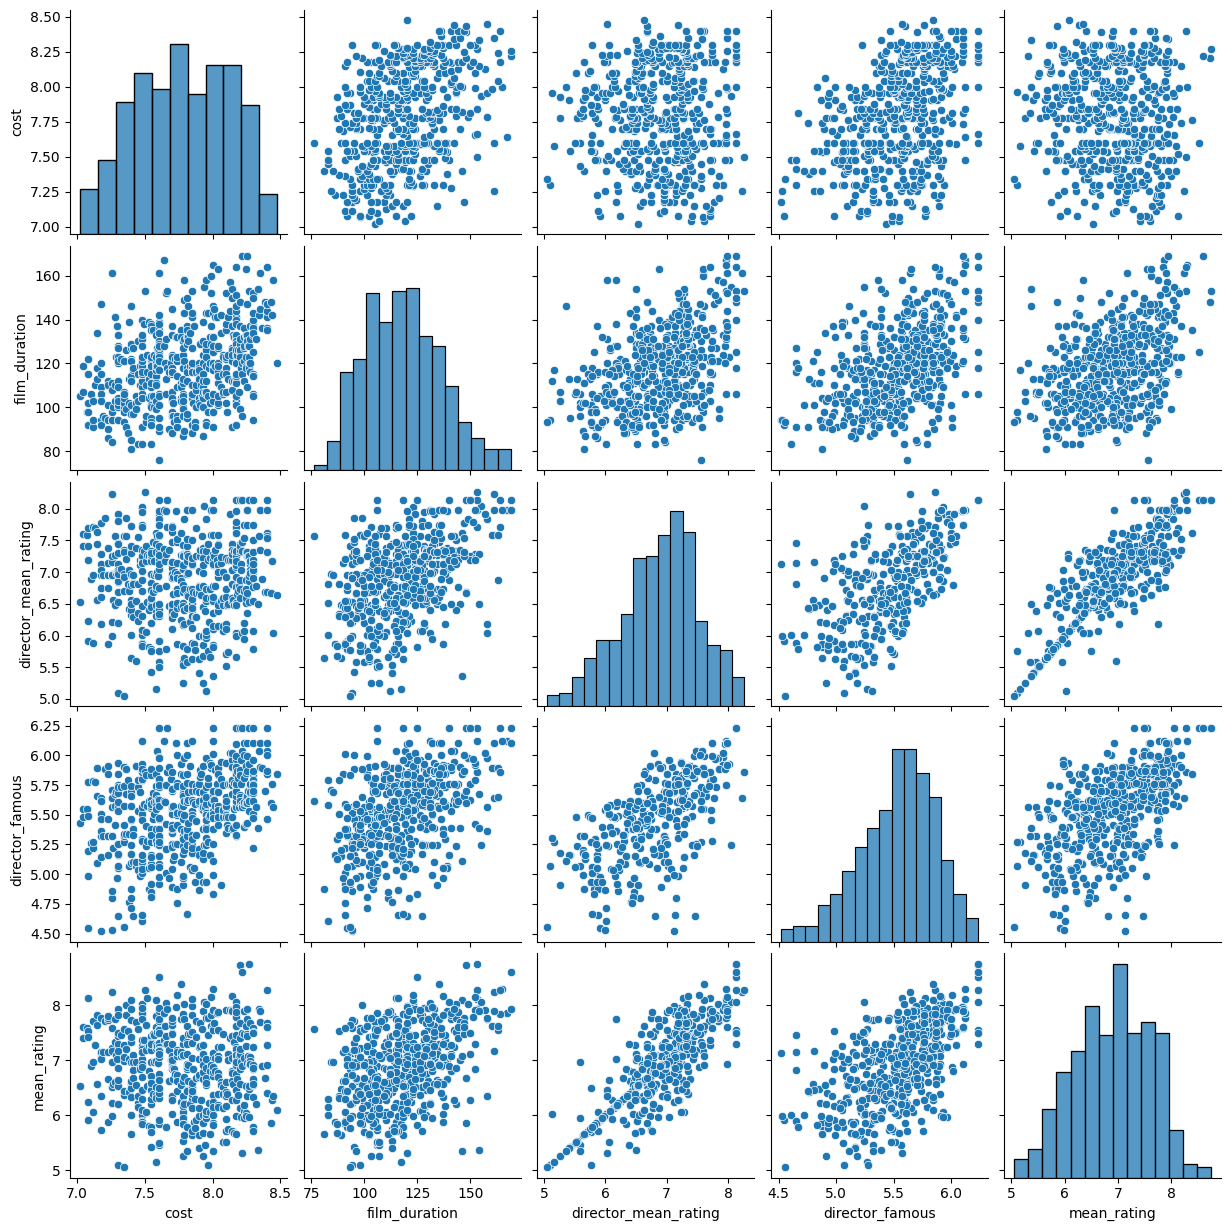

In [ ]:
sns.pairplot(cut_df, vars=['cost', 'film_duration', "director_mean_rating", "director_famous", 'mean_rating']);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=3365, shuffle=True)

In [ ]:
scaler =  StandardScaler()

X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)
mean_squared_error(y_test, lr.predict(X_test_transformed), squared=False)

0.25382039941666606

In [ ]:
def predict_random_box_office_example(X, y, model, transformer):
  i = np.random.randint(0, len(X))
  X_example = X.iloc[i, :]
  y_example = y.iloc[i, :]
  X_ex_tr = transformer.transform(X_example.to_numpy().reshape(1, -1))
  y_true = round(10 ** y_example.values[0],3)
  y_pred = round(10 ** model.predict(X_ex_tr)[0][0],3)
  error = round(((y_true - y_pred) / y_true) * 100, 3)
  print('Prediction:', y_pred, '\nTrue value:', y_true, '\nError:', error, '%')

In [ ]:
predict_random_box_office_example(X_test, y_test, lr, scaler)

Prediction: 870993463.824 
True value: 1081041287.0 
Error: 19.43 %


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
X = df[['cost', 'film_duration', "director_mean_rating", "director_famous"]]
y = df[['box_office']]

X_transformed = scaler.transform(X)

mean_squared_error(y, lr.predict(X_transformed), squared=False)

0.38806591152181014

In [ ]:
predict_random_box_office_example(X, y, lr, scaler)

Prediction: 716563641.82 
True value: 1004934033.0 
Error: 28.695 %


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Модель предсказания кассовых сборов фильма с рейтингом

In [ ]:
X = cut_df[['cost', 'film_duration', "director_mean_rating", "director_famous", 'mean_rating']]
y = cut_df[['box_office']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=3365, shuffle=True)

In [ ]:
scaler =  StandardScaler()

X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)
mean_squared_error(y_test, lr.predict(X_test_transformed), squared=False)

0.2588956686190945

In [ ]:
predict_random_example(X_test, y_test, lr, scaler)

Prediction: 8.27 
True value: 7.997 
Error: -3.414 %


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
X = df[['cost', 'film_duration', "director_mean_rating", "director_famous", 'mean_rating']]
y = df[['box_office']]

X_transformed = scaler.transform(X)

mean_squared_error(y, lr.predict(X_transformed), squared=False)

0.37808611483793353

In [ ]:
predict_random_example(X, y, lr, scaler)

Prediction: 8.588 
True value: 8.944 
Error: 3.98 %


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Выводы
* прогноз рейтинга можно получить достаточно точно на основании данных о фильме, его режиссеров и количестве оценок
* прогноз сборов сложно делать на основании стоимости фильма. Модель может в половину завышать или занижать истинные значения